# Brain Tumor Classification

## By:- Gandhar Ravindra Pansare (Indiana University, Bloomington)
## Guided By:- Professor Krista Li

### Project Overview
This project focuses on building a deep learning model that can analyze brain MRI scans and classify them into one of four categories:
- Glioma Tumor
- Meningioma Tumor
- Pituitary Tumor
- No Tumor

The goal is to explore how well a convolutional neural network (CNN), especially a pretrained model like ResNet18, can be adapted to help with tumor detection from medical images.

---

### Dataset Summary
The dataset used in this project is publicly available on Kaggle and contains around 7,000 brain MRI images. It is organized into **Training** and **Testing** folders, each with subfolders for the four tumor classes. The images are in JPG format, and sizes vary slightly, so they are resized during preprocessing to ensure consistency.

---

### Why This Matters
Brain tumors can have serious health impacts, and early, accurate diagnosis is crucial for better outcomes. Radiologists often rely on MRI scans to detect and classify tumors, this project aims to support that process by training a model that can assist in identifying tumor types automatically and quickly.

---

### How This Project Works
Using a pretrained ResNet18 model, this project applies transfer learning: the base of the model remains unchanged, while the final classification layers are retrained to identify tumor types based on the MRI images. The model is trained, validated, and tested, and its performance is evaluated using accuracy metrics and visual tools like confusion matrices.

---

### Final Thoughts
While this model is not meant to replace medical experts, it shows how AI tools can support medical diagnosis by reducing manual effort and speeding up the detection process. The hope is that projects like this can contribute to making healthcare more efficient and accessible in the future.


In [1]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from torchvision import datasets, transforms, models

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

from torchmetrics.classification import MulticlassAccuracy

# Loading the data

In [2]:
#Path to the main dataset directory
base_directory = '/kaggle/input/brain-tumor-mri-dataset'

#Paths to the subfolders for training and testing data
train_dir = os.path.join(base_directory, 'Training')
test_dir = os.path.join(base_directory, 'Testing')

#Image preprocessing target size for the CNN input
target_size = (224, 224)

#Random seed for reproducibility
random_state = 42

#Batch size to be used in DataLoaders
batch_size = 32

#Number of classes in the classification task
num_classes = 4

#Check if GPU is available, else use CPU (for faster computation)
device = "cuda" if torch.cuda.is_available() else "cpu"

#Dictionary mapping class folder names to numeric labels
label_map = {
    'notumor': 0,
    'glioma': 1,
    'meningioma': 2,
    'pituitary': 3
}

In [3]:
#List all category folder names in the training directory
categories = sorted(os.listdir(train_dir))
print("Categories:", categories)

Categories: ['glioma', 'meningioma', 'notumor', 'pituitary']


# Exploratory Data Analysis

In [4]:
#Function to display images
def show_sample_images(data_folder, samples_per_class=4, resize_dim=(224, 224)):

    path_to_data = os.path.join(base_directory, data_folder)
    fig, axs = plt.subplots(nrows=len(categories), ncols=samples_per_class, figsize=(16, 10))
    fig.suptitle(f"Visual Overview of '{data_folder}' Dataset", fontsize=16, y=1.02)

    for idx, class_name in enumerate(categories):
        class_dir = os.path.join(path_to_data, class_name)
        image_list = [img for img in os.listdir(class_dir) if img.lower().endswith(('jpg', 'jpeg', 'png'))]

        chosen_images = random.choices(image_list, k=min(samples_per_class, len(image_list)))

        for j, img_file in enumerate(chosen_images):
            img_path = os.path.join(class_dir, img_file)
            image = Image.open(img_path).resize(resize_dim)

            axs[idx, j].imshow(image, cmap='gray')
            axs[idx, j].set_title(f"{class_name}", fontsize=9)
            axs[idx, j].axis('off')

    plt.tight_layout()
    plt.show()


In [5]:
#Function to visualize the number of classes in each subfolder
def visualize_class_counts(folder_name):
    #Define colorblind-friendly colors for each class
    cb_colors = ['#0072B2', '#D55E00', '#009E73', '#CC79A7']
    class_counts = {}
    split_path = os.path.join(base_directory, folder_name)

    for label in categories:
        label_path = os.path.join(split_path, label)
        img_files = [f for f in os.listdir(label_path) if f.lower().endswith(('jpg', 'jpeg', 'png'))]
        class_counts[label] = len(img_files)

    #Plotting
    plt.figure(figsize=(8, 5))
    plt.bar(
        list(class_counts.keys()), 
        list(class_counts.values()), 
        color=cb_colors[:len(class_counts)]  # Apply one color per bar
    )
    plt.title(f"Image Count per Class in '{folder_name}' Set", fontsize=14)
    plt.xlabel("Tumor Category")
    plt.ylabel("Image Count")
    plt.xticks(rotation=15)
    plt.grid(axis='y', linestyle=':', linewidth=0.7, alpha=0.6)
    plt.show()

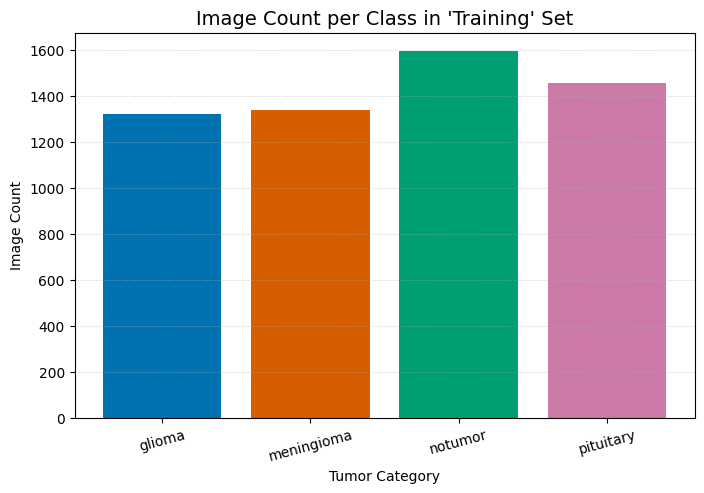

In [6]:
visualize_class_counts('Training')

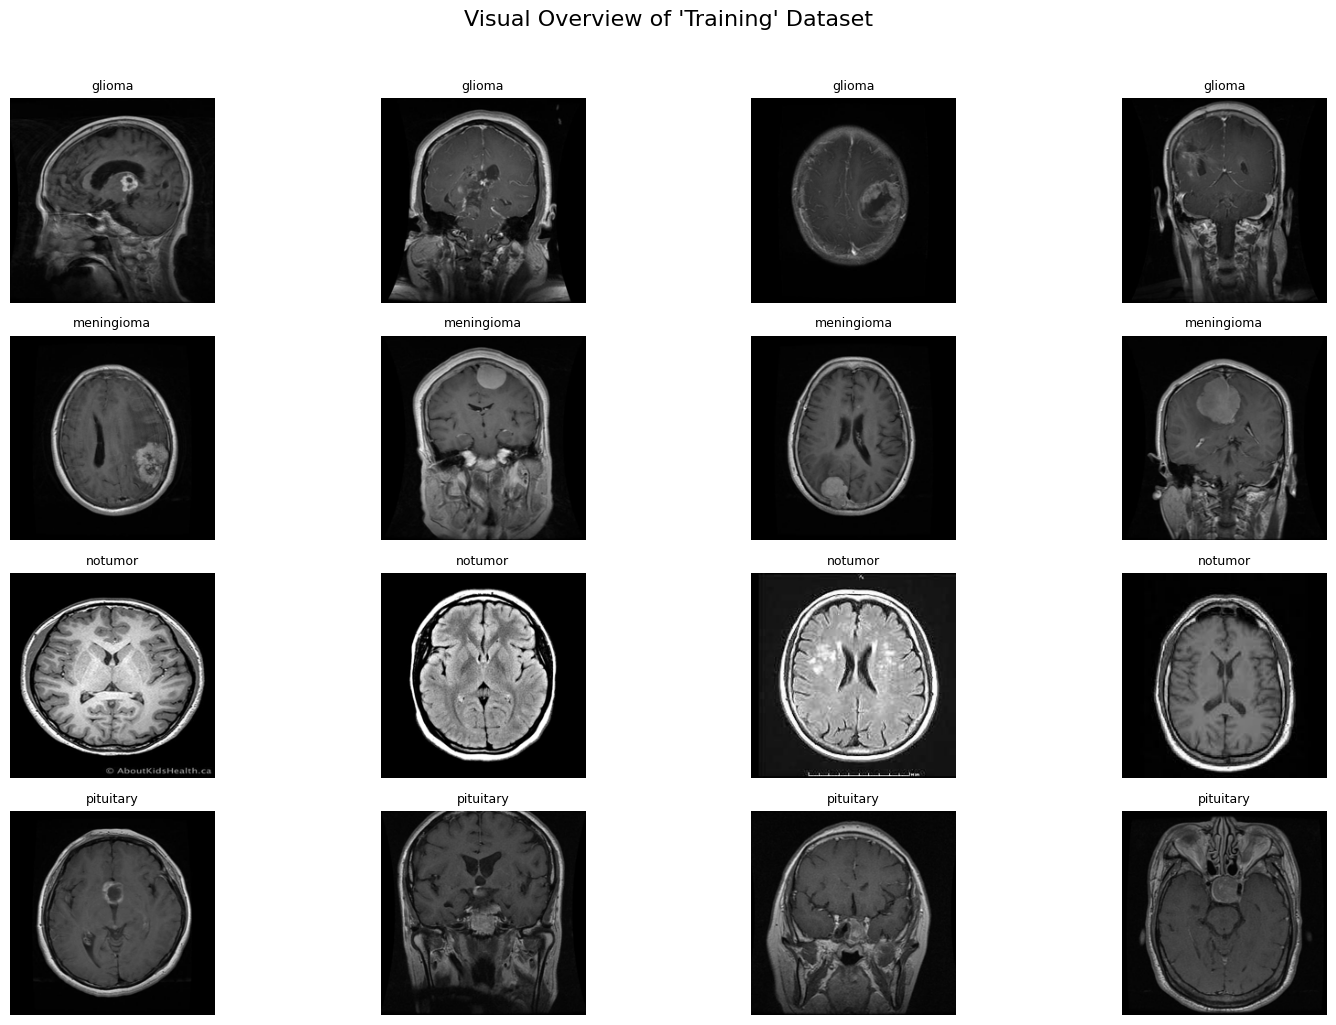

In [7]:
show_sample_images('Training')

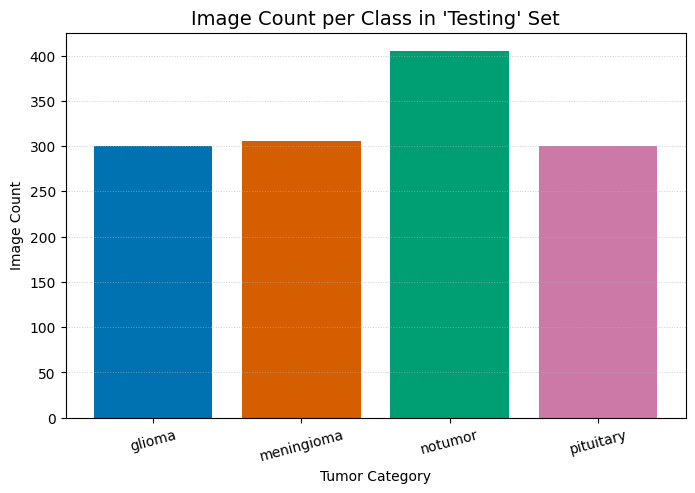

In [8]:
visualize_class_counts('Testing')

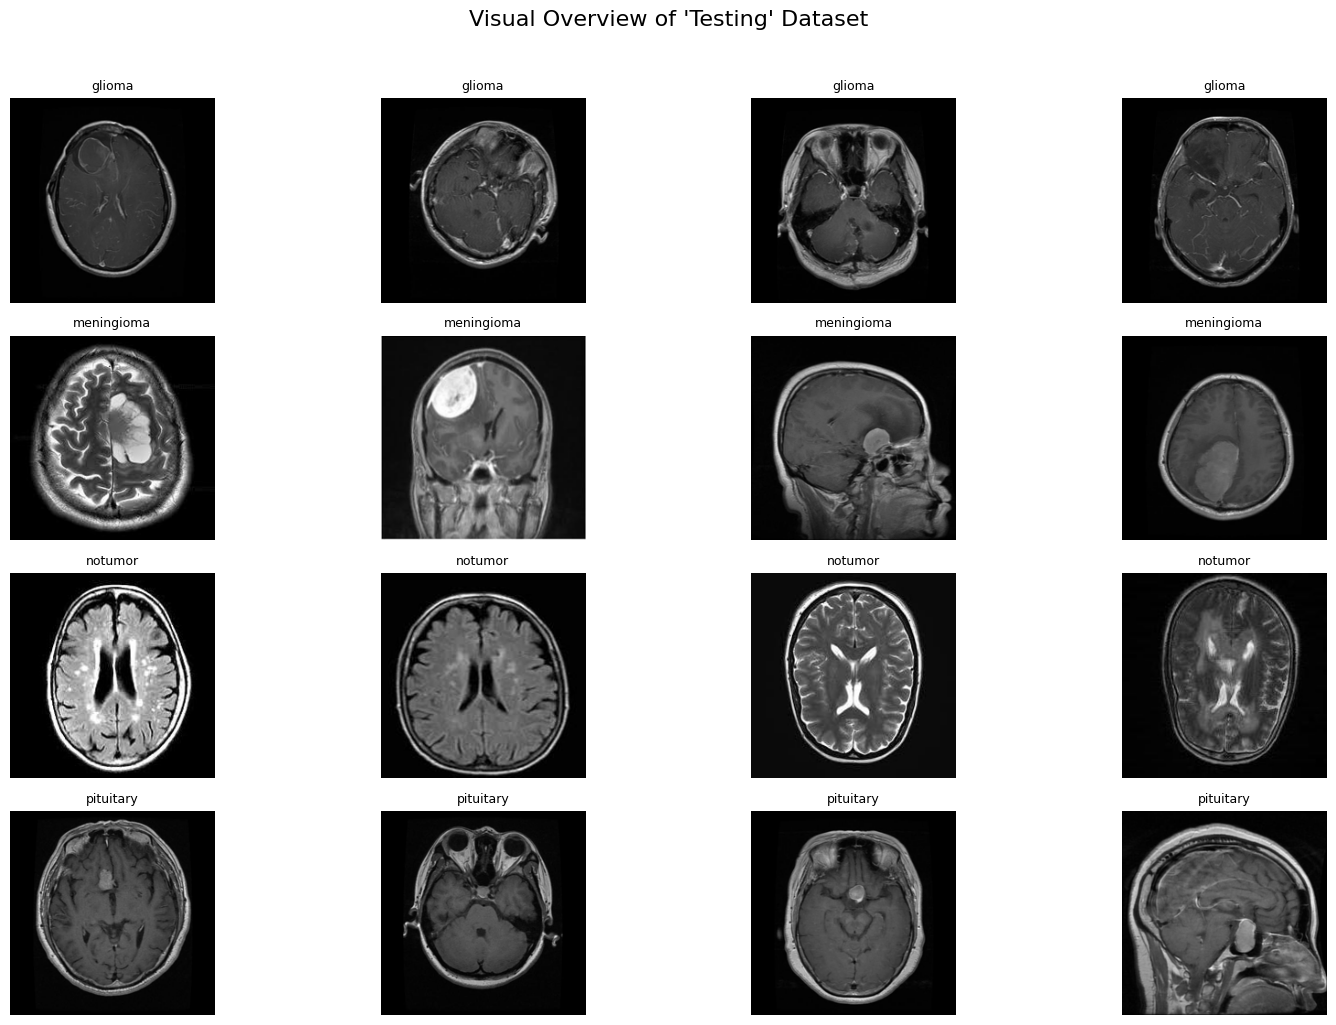

In [9]:
show_sample_images('Testing')

**Exploratory Data Analysis**

The aim of this initial exploratory step was to get a better understanding of the dataset before starting model development. To begin with, the number of images available in each brain tumor category was visualized for both the training and testing sets. This helped check whether the dataset was balanced or skewed toward any particular class. The plots showed a fairly even distribution across all four classes, i.e. glioma, meningioma, notumor, and pituitary, with a slightly higher number of images in the notumor category. Colorblind-friendly colors were used in the charts to improve accessibility and visual clarity.

In addition to the distribution analysis, a few sample MRI images were displayed from each class. This provided a quick visual reference to confirm that the images were properly organized and varied enough to support a classification task. It also helped in identifying the quality and format of the data.

# Data Preprocessing

In [10]:
#Function to build dataframe
def build_dataframe(root_dir, label_dict):
    paths, labels = [], []
    for class_name in sorted(label_dict.keys()):
        class_folder = os.path.join(root_dir, class_name)
        for file in os.listdir(class_folder):
            if file.lower().endswith(('.jpg', '.jpeg', '.png')):
                paths.append(os.path.join(class_folder, file))
                labels.append(label_dict[class_name])
    return pd.DataFrame({'file_path': paths, 'label': labels})

In [11]:
#Transformations applied to training images - includes augmentation
train_transforms = transforms.Compose([
    transforms.Resize(target_size),                       #Resize all images to target dimensions
    transforms.RandomRotation(degrees=15),                #Add slight rotation for variety
    transforms.RandomHorizontalFlip(p=0.5),               #Flip images randomly to reduce overfitting
    transforms.ColorJitter(brightness=0.2, contrast=0.2), #Slight brightness/contrast changes
    transforms.ToTensor(),                                #Convert image to PyTorch tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406],      #Normalize using ImageNet stats
                         std=[0.229, 0.224, 0.225])
])

#Transformations applied to validation and test images — no augmentation
test_transforms = transforms.Compose([
    transforms.Resize(target_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

To prepare the MRI images for input into a pretrained convolutional neural network, a set of image transformations is applied. These transformations not only ensure that all inputs conform to the models expected format, but also enhance the models ability to generalize through data augmentation. Below is a breakdown of each step used in the training and test transformations:

#### `transforms.Resize(target_size)`
All images are resized to a fixed size (224x224 pixels) to match the input requirements of common pretrained CNNs such as ResNet or VGG. This ensures consistent input dimensions across the dataset, which is necessary because neural networks cannot process variable-sized inputs without custom architecture.

#### `transforms.RandomRotation(degrees=15)`
This randomly rotates the image within a range of ±15 degrees. It simulates slight changes in image orientation that could occur in real MRI scans, helping the model learn rotational invariance and reducing overfitting to one specific angle.

#### `transforms.RandomHorizontalFlip(p=0.5)`
This randomly flips images horizontally with a 50% probability. While MRI images are typically direction-sensitive in clinical settings, flipping in this context is still a useful augmentation technique to increase data variability.

#### `transforms.ColorJitter(brightness=0.2, contrast=0.2)`
This randomly changes the brightness and contrast of the image within a small range. Although MRIs are grayscale in nature, they are stored in RGB format here. Small jitter in pixel intensities can help the model generalize better to images acquired with different settings or lighting conditions.

#### `transforms.ToTensor()`
This step converts the image from a PIL Image (range [0, 255]) to a PyTorch tensor (range [0.0, 1.0]). This is necessary for feeding the image into a neural network and enabling GPU-based computation.

#### `transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])`
Normalization standardizes the image pixel values based on the mean and standard deviation of the ImageNet dataset, which is what the pretrained model was originally trained on. This ensures that the pixel intensity distribution of the input matches what the pretrained CNN expects, improving training stability and performance.

#### Validation/Test Transformations
For validation and test sets, only resizing, tensor conversion, and normalization are applied, without any augmentations. This is important because these sets are used to **evaluate performance**, and hence they should reflect real-world input as closely as possible, without artificial distortions.

In [12]:
#Defining custom dataset class to efficiently load MRI images and corresponding labels from a df.
class BrainTumorDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.paths = dataframe['file_path'].values
        self.labels = dataframe['label'].values
        self.transform = transform

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, idx):
        image = Image.open(self.paths[idx]).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, self.labels[idx]


A custom PyTorch dataset class is defined to efficiently load MRI images and their corresponding labels from a dataframe. This is necessary because the default `ImageFolder` method in PyTorch expects a folder-based label structure, while this project uses a pre-generated dataframe containing file paths and label mappings.

#### `__init__(self, dataframe, transform=None)`
The constructor takes a pandas dataframe that includes two columns: `'file_path'` and `'label'`. These columns contain the full path to each image file and its associated numeric label, respectively. The `transform` argument allows image preprocessing (such as resizing or normalization) to be applied at the time of loading.

- `self.paths` stores all image file paths as a NumPy array.
- `self.labels` stores the corresponding class labels.
- `self.transform` keeps track of any transformations to be applied on the image.

#### `__len__(self)`
This method returns the total number of samples in the dataset. It's required by PyTorch so that the DataLoader knows how many batches to generate.

#### `__getitem__(self, idx)`
This function retrieves a single sample (image and label pair) from the dataset using an index. The image is first opened using the PIL library and converted to RGB format. If any transformation (like resizing, normalization, etc.) is provided, it's applied here. The method then returns a tuple: `(transformed_image_tensor, label)`.

In [13]:
#Making training and testing dataframes
train_df = build_dataframe(train_dir, label_map)
test_df = build_dataframe(test_dir, label_map)

#Split the test set into validation and test halves
val_df, test_df_split = train_test_split(test_df, test_size=0.5, random_state=random_state)

#Initialize datasets
train_dataset = BrainTumorDataset(train_df, transform=train_transforms)
val_dataset = BrainTumorDataset(val_df.reset_index(drop=True), transform=test_transforms)
test_dataset = BrainTumorDataset(test_df_split.reset_index(drop=True), transform=test_transforms)

#Prepare DataLoaders for batch training
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

This part splits the original test data into two halves: one for validation during training and the other for final evaluation. This avoids data leakage and ensures reliable model tuning. Using PyTorch's DataLoader wraps the dataset objects into iterable batches, making training more efficient and allowing for GPU acceleration. The shuffle=True option for the training set helps ensure that each batch contains a good mix of different classes.

# Modeling

### Model Overview: Brain Tumor Classification Using ResNet18

To classify brain MRI images into four categories - glioma, meningioma, pituitary tumor, and no tumor, a convolutional neural network based on the pretrained ResNet18 architecture is used. ResNet18 is a deep learning model that has already learned how to recognize general features in images like edges, textures, and patterns by being trained on millions of images from the ImageNet dataset. Instead of training a model from scratch, which would require a massive amount of data and time, ResNet18 acts as a strong starting point.

In this setup, the earlier layers of ResNet18 are frozen so they retain their existing knowledge, and only the final layers are replaced and trained on the brain tumor data. A custom classifier head is added at the end of the model to map the extracted features to one of the four tumor types. This head includes a fully connected layer with 256 hidden units, a ReLU activation to help capture non-linear patterns, a dropout layer to reduce overfitting, and a final output layer with 4 units (one for each class). The model outputs a set of scores for each class, and the one with the highest score is selected as the predicted tumor type.


In [14]:
#Load pretrained ResNet18
model = models.resnet18(weights='IMAGENET1K_V1') 

#Freeze backbone layers
for layer in model.parameters():
    layer.requires_grad = False

#Get the number of input features to the original final layer
input_features = model.fc.in_features

#Replace with a custom classification head
model.fc = nn.Sequential(
    nn.Linear(input_features, 256),  
    nn.ReLU(),
    nn.Dropout(0.4),                
    nn.Linear(256, num_classes)
)

model = model.to(device)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 225MB/s]


This block of code sets up the model for classifying brain tumors using a pretrained ResNet18 from PyTorch’s model library.

- `models.resnet18(weights='IMAGENET1K_V1')`: Loads a version of ResNet18 that was already trained on ImageNet, a huge dataset of natural images. This helps the model understand general image features like edges, textures, and shapes.

- `for layer in model.parameters(): layer.requires_grad = False`: Freezes all the layers in the base network so that their weights don't get updated during training. This way, the model keeps what it learned from ImageNet and we only train the last few layers for our specific task.

- `input_features = model.fc.in_features`: Retrieves the number of input units going into the original last (fully connected) layer.

- `model.fc = nn.Sequential(...)`: Replaces the final layer with a custom classifier. Instead of using the original layer (which was designed for 1000 ImageNet classes), we add:
  - A linear layer with 256 nodes
  - A ReLU activation to introduce non-linearity
  - A dropout layer (40%) to prevent overfitting
  - A final output layer with 4 units - one for each tumor class

In [15]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

The model uses `CrossEntropyLoss` as the loss function, which is well-suited for multi-class classification problems. It works by comparing the model’s raw output scores (logits) with the correct class labels and penalizing incorrect predictions more heavily. Internally, it applies a softmax function to convert the outputs into probabilities and then calculates how far off the predicted class is from the true class.

For optimization, the Adam optimizer is used, which is an adaptive learning algorithm that adjusts the learning rate during training. It's known for being efficient and well-suited for problems involving a large number of parameters. The optimizer is set to update only the parameters of the final classification head (`model.fc.parameters()`), since the rest of the model (the ResNet18 backbone) is frozen. The learning rate is set to `0.001`.

In [16]:
#Function to train the model
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=40, patience=7):
    best_val_loss = float('inf')
    patience_counter = 0

    for epoch in range(epochs):
        model.train()
        total_loss, total_correct = 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * images.size(0)
            total_correct += (outputs.argmax(dim=1) == labels).sum().item()

        avg_train_loss = total_loss / len(train_loader.dataset)
        avg_train_acc = total_correct / len(train_loader.dataset)

        #Validation
        model.eval()
        val_loss, val_correct = 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * images.size(0)
                val_correct += (outputs.argmax(dim=1) == labels).sum().item()

        avg_val_loss = val_loss / len(val_loader.dataset)
        avg_val_acc = val_correct / len(val_loader.dataset)

        print(f"Epoch {epoch+1}/{epochs} | "
              f"Train Loss: {avg_train_loss:.4f}, Acc: {avg_train_acc:.4f} | "
              f"Val Loss: {avg_val_loss:.4f}, Acc: {avg_val_acc:.4f}")

        #Early Stopping Check
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            patience_counter = 0
            #Save the best model
            torch.save(model.state_dict(), 'best_model.pth')
        else:
            patience_counter += 1
            if patience_counter >= patience:
                print(f"Early stopping triggered at epoch {epoch+1}")
                break

### Training Function with Early Stopping

This function handles the model training process and includes early stopping to prevent overfitting. The model is trained over a defined number of epochs (default is 40), but it will stop early if the validation loss doesn’t improve for a certain number of consecutive epochs (controlled by the `patience` parameter).

#### Training Phase
- The model is set to training mode using `model.train()`.
- For each batch of images and labels:
  - The data is moved to the correct device (CPU or GPU).
  - Predictions are made using `model(images)`.
  - The loss between predictions and actual labels is computed.
  - The optimizer updates the model weights to reduce the loss using backpropagation.

Training loss and accuracy are calculated for the entire training set after each epoch.

#### Validation Phase
- The model is switched to evaluation mode using `model.eval()` to disable dropout and other training-specific behavior.
- No gradients are calculated during validation to save memory and speed things up (`torch.no_grad()`).
- The validation loss and accuracy are computed in a similar way as training but without updating the model.

#### Early Stopping
- After each epoch, the validation loss is compared to the best seen so far.
- If it improves, the model is saved as the current best (`best_model.pth`) and the patience counter is reset.
- If not, the patience counter increases. If no improvement is seen for `patience` number of epochs, training is stopped early.

This helps avoid overfitting by stopping training once the model stops improving on unseen data.


In [17]:
train_model(model, train_loader, val_loader, loss_fn, optimizer, epochs=60, patience=7)

Epoch 1/60 | Train Loss: 0.6174, Acc: 0.7570 | Val Loss: 0.5367, Acc: 0.7832
Epoch 2/60 | Train Loss: 0.4579, Acc: 0.8267 | Val Loss: 0.4102, Acc: 0.8504
Epoch 3/60 | Train Loss: 0.4088, Acc: 0.8452 | Val Loss: 0.3817, Acc: 0.8458
Epoch 4/60 | Train Loss: 0.3692, Acc: 0.8585 | Val Loss: 0.3813, Acc: 0.8443
Epoch 5/60 | Train Loss: 0.3523, Acc: 0.8676 | Val Loss: 0.3942, Acc: 0.8382
Epoch 6/60 | Train Loss: 0.3615, Acc: 0.8652 | Val Loss: 0.3761, Acc: 0.8504
Epoch 7/60 | Train Loss: 0.3414, Acc: 0.8673 | Val Loss: 0.3710, Acc: 0.8550
Epoch 8/60 | Train Loss: 0.3306, Acc: 0.8799 | Val Loss: 0.3262, Acc: 0.8565
Epoch 9/60 | Train Loss: 0.3202, Acc: 0.8778 | Val Loss: 0.3248, Acc: 0.8595
Epoch 10/60 | Train Loss: 0.3258, Acc: 0.8820 | Val Loss: 0.3095, Acc: 0.8733
Epoch 11/60 | Train Loss: 0.3159, Acc: 0.8773 | Val Loss: 0.2991, Acc: 0.8931
Epoch 12/60 | Train Loss: 0.3037, Acc: 0.8815 | Val Loss: 0.3602, Acc: 0.8550
Epoch 13/60 | Train Loss: 0.3032, Acc: 0.8822 | Val Loss: 0.3187, Acc: 0.

In [18]:
#Function to evaluate and plot the model
def evaluate_and_plot(model, test_loader, class_names):
    model.eval()
    preds = []
    true = []

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            outputs = model(images)
            predictions = outputs.argmax(dim=1).cpu().numpy()
            preds.extend(predictions)
            true.extend(labels.numpy())

    print("\n Classification Report:")
    print(classification_report(true, preds, target_names=class_names))

    print("\n Confusion Matrix:")
    cm = confusion_matrix(true, preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap='Purples')
    plt.title("Confusion Matrix on Test Data")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

### Model Evaluation and Visualization

This function is used to evaluate how well the trained model performs on the **test set** and to visualize the results.

#### Evaluation Mode
The model is switched to evaluation mode using `model.eval()`, which disables training-specific features like dropout.

#### No Gradients Needed
`torch.no_grad()` is used to turn off gradient tracking, which makes evaluation faster and more memory-efficient since we’re not training or updating weights.

#### Loop Through Test Set
The function loops through the test data batch by batch:
- It sends each batch of images.
- The model makes predictions.
- The `argmax(dim=1)` operation is used to get the index of the class with the highest score for each image (i.e., the predicted label).
- These predictions and the true labels are collected into lists for later analysis.

#### Classification Report
The `classification_report()` from `sklearn` prints detailed metrics for each class:
- **Precision**: Out of all predicted X, how many were actually X?
- **Recall**: Out of all actual X, how many did we correctly identify?
- **F1-score**: A balance between precision and recall.
- **Support**: How many true samples of each class were in the test set.

#### Confusion Matrix
The `confusion_matrix()` shows a grid of how many images of each class were correctly or incorrectly predicted. The diagonal shows correct predictions. Misclassifications appear off the diagonal.


 Classification Report:
              precision    recall  f1-score   support

     notumor       0.94      0.99      0.96       192
      glioma       0.95      0.82      0.88       151
  meningioma       0.82      0.85      0.83       164
   pituitary       0.95      0.96      0.95       149

    accuracy                           0.91       656
   macro avg       0.91      0.91      0.91       656
weighted avg       0.91      0.91      0.91       656


 Confusion Matrix:


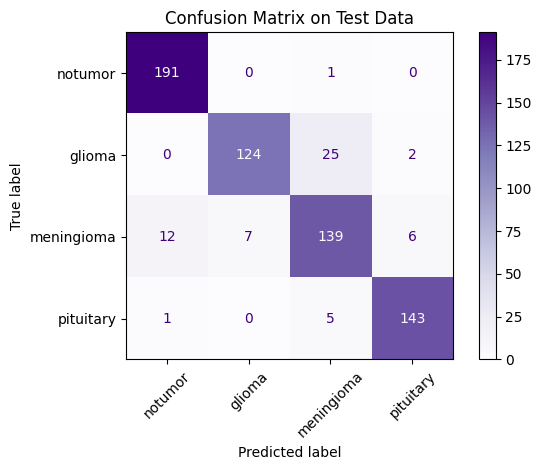

In [19]:
class_names = list(label_map.keys())
evaluate_and_plot(model, test_loader, class_names)

### Model Performance Summary

The classification report and confusion matrix show that the model performed very well overall, achieving an accuracy of **91%** on the test set.

- **Notumor** and **Pituitary** classes were classified with very high precision and recall (F1-scores above 0.95), showing the model is highly confident and consistent in detecting these cases.
- **Glioma** had strong precision (0.95) but slightly lower recall (0.82), meaning the model is sometimes missing glioma cases.
- **Meningioma** was the most challenging class, with an F1-score of 0.83. The confusion matrix shows some misclassifications between meningioma and glioma, which may be due to visual similarity in MRI scans.
